# Logistic regression

Despite the name, [logistic regression](https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) is a binary classification algorithm

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

df_AIMD = pd.read_csv("Dist_AIMD.csv") 
df_MD = pd.read_csv('Dist_MD.csv')
df_fin = pd.concat([df_AIMD, df_MD])

df_shuffle = shuffle(df_fin, random_state=0)

df_shuffle.head()

,Class,ClassName,S-O1,S-O2,S-H1,S-H2,C-O1,C-O2,C-H1,C-H2,N-O1,N-O2,N-H1,N-H2
200,0,MD,3.058644,3.268839,2.127982,2.398241,2.880752,3.231719,2.107106,2.465597,2.722132,2.823587,1.790810,1.919631
170,1,AIMD,3.249995,3.263349,2.265893,2.361130,3.094923,3.190536,2.335263,2.485889,2.854410,2.938808,1.871487,2.033413
15,0,MD,2.914829,2.965123,2.012212,2.158510,2.984337,3.054808,2.247004,2.361860,2.715118,2.766487,1.803254,1.861320
181,0,MD,2.874340,3.234227,1.969793,2.422937,3.453376,3.579303,2.573053,2.658360,2.732942,2.971228,1.791051,2.060111
99,0,MD,2.998400,3.009045,2.113534,2.155761,3.038301,3.043577,2.177829,2.206199,2.713162,2.785390,1.798333,1.852806


In [2]:
from sklearn.model_selection import train_test_split

# Data selection 
# First we shall select the closest oxygens and later add the rest to see the effects of increasing features
# Then we will repeat it for hydrogens
X3 = df_shuffle[['S-O1', 'C-O1', 'N-O1']]
X6 = df_shuffle[['S-O1', 'C-O1', 'N-O1', 'S-O2', 'C-O2', 'N-O2']]

H3 = df_shuffle[['S-H1', 'C-H1', 'N-H1']]
H6 = df_shuffle[['S-H1', 'C-H1', 'N-H1', 'S-H2', 'C-H2', 'N-H2']]
y = df_shuffle['Class']

# Splitting the data into training(80%) and test(20%) set

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.20, random_state=0)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y, test_size=0.20, random_state=0)


## Logistic regression 

We shall follow the same idea as before, fit for oxygens first and then hydrogens and observe the differences

Logistic regression model can print out the feature weights, i.e., which can be interpreted as feature importance that the model uses in classifying MD and AIMD snapshots. Reading more into the feature importance is not advisable since they tend to differ from one model to another. 

In [3]:
from sklearn.linear_model import LogisticRegression
import my_utils

lr = LogisticRegression(C=100, random_state=0).fit(X3_train, y3_train)

print("Number of features seen in the fit: ",lr.n_features_in_)
print("Feature names and weights:\n",sorted(list(zip(lr.feature_names_in_,lr.coef_.flatten())), key=lambda x:x[1], reverse=True))
print("Accuracy for LogisticRegression(C=100) with 3 features: ", lr.score(X3_test, y3_test))

lr = LogisticRegression(C=100, random_state=0).fit(X6_train, y6_train)

print("\nNumber of features seen in the fit: ",lr.n_features_in_)
print("Feature names and weights:\n",sorted(list(zip(lr.feature_names_in_,lr.coef_.flatten())), key=lambda x:x[1], reverse=True))
print("Accuracy for LogisticRegression(C=100) with 6 features: ", lr.score(X6_test, y6_test))


Number of features seen in the fit:  3
Feature names and weights:
 [('N-O1', 10.99802432512), ('S-O1', 8.105463130062185), ('C-O1', 7.884855985049137)]
Accuracy for LogisticRegression(C=100) with 3 features:  0.8333333333333334

Number of features seen in the fit:  6
Feature names and weights:
 [('N-O2', 14.927493049461713), ('C-O2', 7.143157910723131), ('S-O1', 5.395758750773344), ('C-O1', 3.773618734355424), ('S-O2', 3.678268650991656), ('N-O1', 0.6831900522373792)]
Accuracy for LogisticRegression(C=100) with 6 features:  0.9404761904761905


### For the model with 3 features, the N-O1 feature holds the most weight in classification, which makes sense if we consider the RDF. 

### For 6 features however, N-O2 holds the highest weight followed by C-O2, and N-O1 has the lowest weight. 

In [4]:
#Cross validation scores
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(C=100, random_state=0)

# 5 fold cross valildation for the classifier with 3 and 6 features respectively
cv3_scores = cross_val_score(lr, X3, y, cv=5)
print(cv3_scores, np.mean(cv3_scores))

cv6_scores = cross_val_score(lr, X6, y, cv=5)
print(cv6_scores, np.mean(cv6_scores))

[0.86904762 0.89285714 0.81927711 0.93975904 0.81927711] 0.868043602983362
[0.91666667 0.9047619  0.92771084 0.97590361 0.89156627] 0.9233218588640275


Interestingly, compared to K nearest neighbors case, the cross validation score for the model with 3 features is increased slightly but the one with 6 features decreases, albeit slightly. 

## Validation curve

In logistic regression model the most important parameter is the [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) parameter, C (which is the inverse of regularization strength, i.e., smaller values mean stronger regularization). 

Logistic regression has L2 regularization by default and we will see the effects of changing C on the training and cross validation score

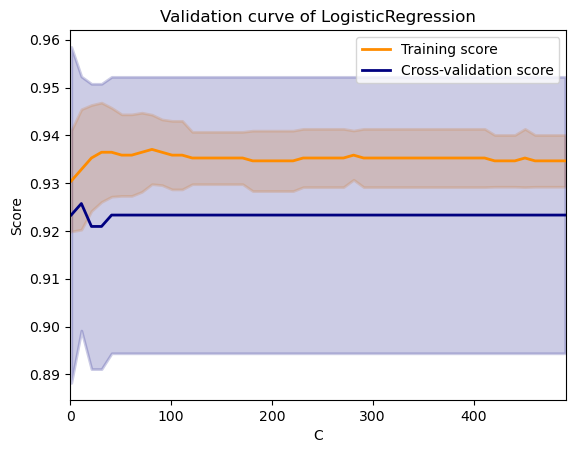

In [5]:
from sklearn.model_selection import validation_curve
import my_utils
param_range = np.arange(1,500,10) # Parameter range for n_neighbors

# Using the dataset with 6 features
train_score, test_score = validation_curve(LogisticRegression(random_state=0), X6, y, 
                                          param_name = 'C', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'LogisticRegression', 'C')

This validation curve shows the effect of changing the L2 regularization strength in the LogisticRegression model. We see the training and cross-validation score slightly increases and converges quickly at C~50. 

There is also the absence of overfitting for any value of C (we tested up to C=1000). The cross validation score converges arounf 0.92 which is similar to the KNN model. 

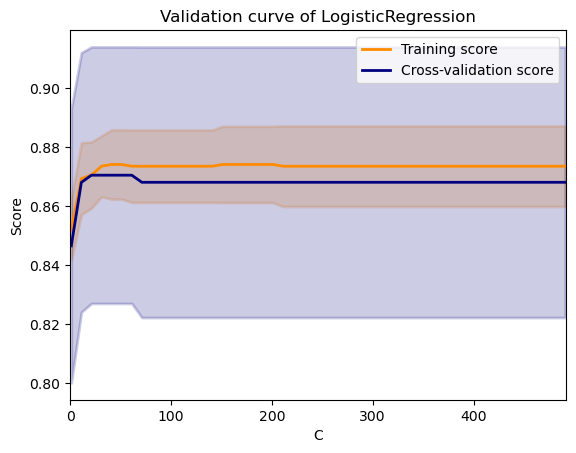

In [6]:
# Using the dataset with 3 features
train_score, test_score = validation_curve(LogisticRegression(random_state=0), X3, y, 
                                          param_name = 'C', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'LogisticRegression', 'C')

The validation curve with the model with 3 features is different from the one with 6 features but the primary difference is the accuracy scores to which both traning and cross validation converge to, which is quite a bit smalller than the model with 6 features. 

There is one other parameter that we should take a look at.

## Solver

Selects the algorithm used in the optimzation problem. The default solver is 'lbfgs', but we will check the cross-validation accuracy of another solver: 'liblinear which is a good choice for small datasets, supports l1 or l2 penalty

In [7]:
lr = LogisticRegression(solver = 'liblinear', C=100, random_state=0)
# 5 fold cross valildation for the classifier with 3 and 6 features respectively
cv3_scores = cross_val_score(lr, X3, y, cv=5)
print("Mean cross-validation score for liblinear solver with 3 features: ", np.mean(cv3_scores))

cv6_scores = cross_val_score(lr, X6, y, cv=5)
print("Mean cross-validation score for liblinear solver with 6 featurs: ", np.mean(cv6_scores))


Mean cross-validation score for liblinear solver with 3 features:  0.8656626506024097
Mean cross-validation score for liblinear solver with 6 featurs:  0.9209695926563397


There is no significant change in the cross-validation score, and so we will keep using the default solver.

## Repeating the above calculations for H

In [8]:
# Train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(H3, y, test_size=0.20, random_state=0)
X6_train, X6_test, y6_train, y6_test = train_test_split(H6, y, test_size=0.20, random_state=0)

# Model fitting and weights

lr = LogisticRegression(C=100, random_state=0).fit(X3_train, y3_train)

print("Number of features seen in the fit: ",lr.n_features_in_)
print("Feature names and weights:\n",sorted(list(zip(lr.feature_names_in_,lr.coef_.flatten())), key=lambda x:x[1], reverse=True))
print("Accuracy for LogisticRegression(C=100) with 3 features: ", lr.score(X3_test, y3_test))

lr = LogisticRegression(C=100, random_state=0).fit(X6_train, y6_train)

print("\nNumber of features seen in the fit: ",lr.n_features_in_)
print("Feature names and weights:\n",sorted(list(zip(lr.feature_names_in_,lr.coef_.flatten())), key=lambda x:x[1], reverse=True))
print("Accuracy for LogisticRegression(C=100) with 6 features: ", lr.score(X6_test, y6_test))


Number of features seen in the fit:  3
Feature names and weights:
 [('C-H1', 10.17482299763578), ('N-H1', 7.297457249450949), ('S-H1', 4.819348260216297)]
Accuracy for LogisticRegression(C=100) with 3 features:  0.8571428571428571

Number of features seen in the fit:  6
Feature names and weights:
 [('C-H2', 12.11247041578433), ('N-H2', 9.574949054014475), ('C-H1', 4.241789853540621), ('S-H1', 3.8793439916124703), ('S-H2', 1.4866518135774367), ('N-H1', 1.3601712327791948)]
Accuracy for LogisticRegression(C=100) with 6 features:  0.9285714285714286


### In case of closest hydrogens the C-H holds significant weight in both cases, and the accuracy is comparable to the oxygen models. Next, we see the effect of cross validation

In [9]:
#Cross validation scores
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(C=100, random_state=0)

# 5 fold cross valildation for the classifier with 3 and 6 features respectively
cv3_scores = cross_val_score(lr, H3, y, cv=5)
print(cv3_scores, np.mean(cv3_scores))

cv6_scores = cross_val_score(lr, H6, y, cv=5)
print(cv6_scores, np.mean(cv6_scores))

[0.86904762 0.88095238 0.8313253  0.92771084 0.84337349] 0.8704819277108434
[0.91666667 0.94047619 0.90361446 0.96385542 0.87951807] 0.9208261617900172


### As seen with the oxygen features, cross validation increases the accuracy of the 3 feature model and slightly lowers the accuracy of the 6 feature model

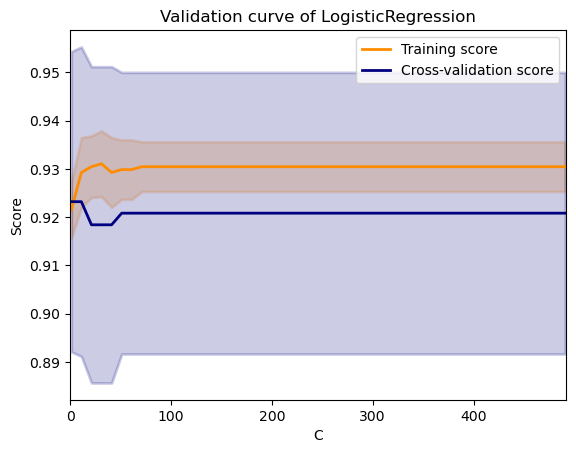

In [10]:
# Validation curves for 6 feature model

train_score, test_score = validation_curve(LogisticRegression(random_state=0), H6, y, 
                                          param_name = 'C', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'LogisticRegression', 'C')

The validation curve does not show new information compared to the oxygen models, i.e., the convergence happens around C ~ 50 and there are no signs of overfitting. The accuracy stabilizes around 0.92.

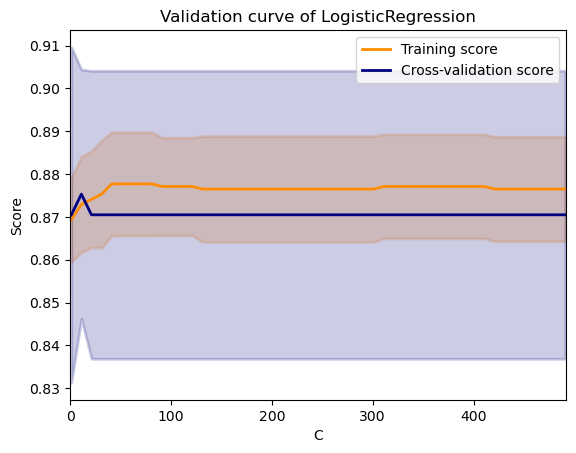

In [11]:
# Validation curves for 3 feature model

train_score, test_score = validation_curve(LogisticRegression(random_state=0), H3, y, 
                                          param_name = 'C', param_range = param_range, cv=5)

my_utils.plot_validation_curve(train_score, test_score, param_range, 'LogisticRegression', 'C')